<a href="https://colab.research.google.com/github/3x10e8/GrFNN-attention/blob/main/two_speakers_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import librosa # already installed
import numpy as np
from numpy import pi as π
from numpy import sin

import IPython
from IPython.display import Audio # for audio playback

import matplotlib.pyplot as plt
%matplotlib inline 
# ! pip install ipympl
#%matplotlib widget
plt.rcParams["figure.figsize"] = (20,3)

# Collect sound samples for processing

In [3]:
# Clone sample files provided with librosa
! git clone https://github.com/librosa/data.git

Cloning into 'data'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 110 (delta 34), reused 93 (delta 21), pack-reused 0
Receiving objects: 100% (110/110), 14.08 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [4]:
LIBROSA_AUDIO_DIR = '/content/data/audio/'
filenames_to_read = ['198-209-0000.hq.ogg', '3436-172162-0000.hq.ogg']
NUM_FILES = len(filenames_to_read)

# Buckets for collecting sample audio and corresponding rates
y_all = []
sr_all = []

# Load the audio data
for filename in filenames_to_read:
  # https://librosa.org/doc/main/generated/librosa.load.html
  y, sr = librosa.load(LIBROSA_AUDIO_DIR + filename)
  y /= abs(max(y)) # normalize
  y_all.append(y)
  sr_all.append(sr)

Duration of 198-209-0000.hq.ogg	10.0s
Sample rate of 198-209-0000.hq.ogg	22050Hz
Duration of 3436-172162-0000.hq.ogg	10.0s
Sample rate of 3436-172162-0000.hq.ogg	22050Hz
Shorten the clips to 10s:


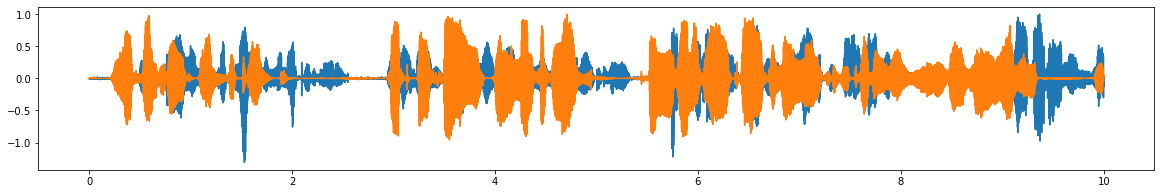

In [44]:
# How long is each sample?
for i in range(NUM_FILES):
  print('Duration of {}\t{}s'.format(filenames_to_read[i], 
                                     len(y_all[i])/sr_all[i]))
  print('Sample rate of {}\t{}Hz'.format(filenames_to_read[i],
                                        sr_all[i]))
  
# Take a smaller clip such that we have the same size for both samples
DUR_s = 10
print('Shorten the clips to {}s:'.format(DUR_s))
for i in range(NUM_FILES):
  tt = np.arange(0, DUR_s, step=1/sr_all[i])
  y_all[i] = y_all[i][:DUR_s*sr_all[i]] # reduce to duration
  plt.plot(tt, y_all[i])

IPython.display.display(Audio(data=y_all[0], rate=sr_all[0]))
IPython.display.display(Audio(data=y_all[1], rate=sr_all[1]))

# Generate a summed cocktail

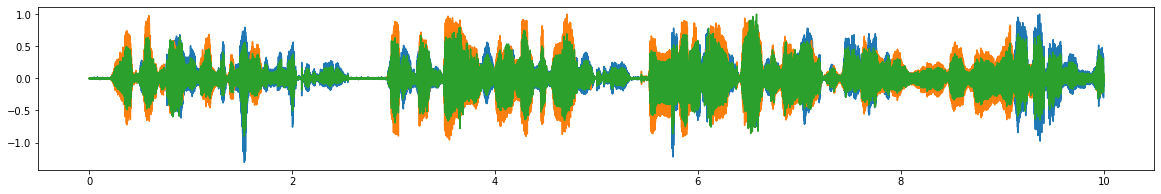

In [13]:
mix = y_all[0] + y_all[1]
mix /= abs(max(mix))
for i in range(NUM_FILES):
  plt.plot(tt, y_all[i])
plt.plot(tt, mix)

IPython.display.display(Audio(data=mix, rate=sr_all[1]))

# Extract the envelope

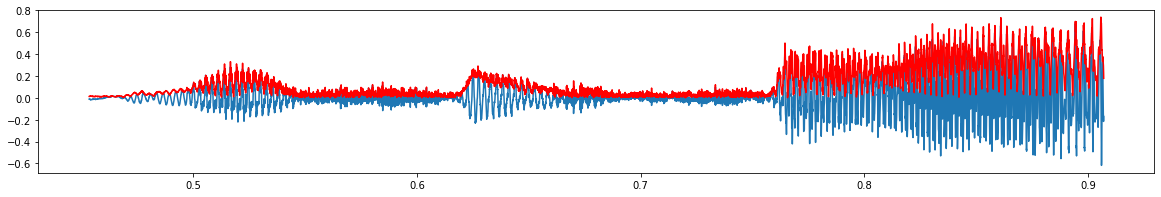

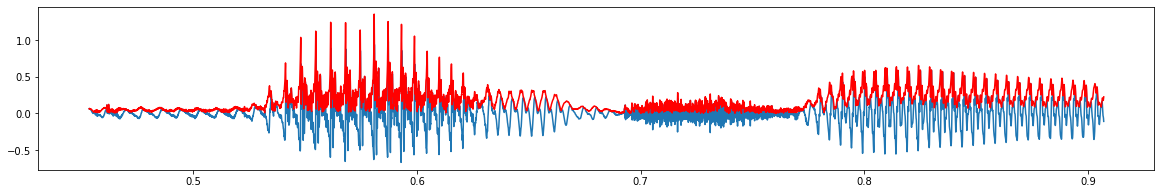

In [15]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
from scipy.signal import hilbert
for i in range(NUM_FILES):
  analytic_signal = hilbert(y_all[i])
  amplitude_envelope = np.abs(analytic_signal)
  plt.figure()
  X_RANGE = range(10000, 20000)
  plt.plot(tt[X_RANGE], y_all[i][X_RANGE])
  plt.plot(tt[X_RANGE], amplitude_envelope[X_RANGE], 'r')

## Low pass filter the envelope

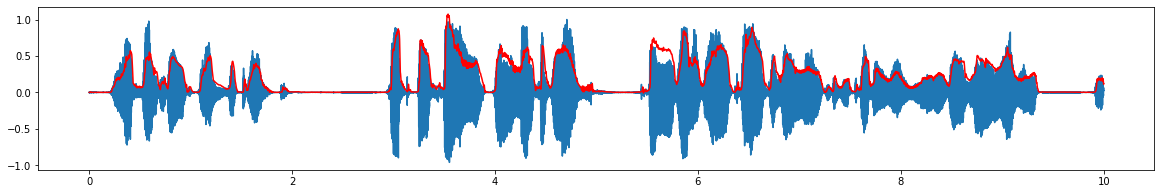

In [29]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
from scipy import signal
sos = signal.butter(N=10, Wn=100, btype='lp', fs=sr_all[0], output='sos')
filtered = signal.sosfilt(sos, amplitude_envelope*1.5) # TODO calculate the gain of the filter

plt.plot(tt, y_all[1])
plt.plot(tt, filtered, 'r')

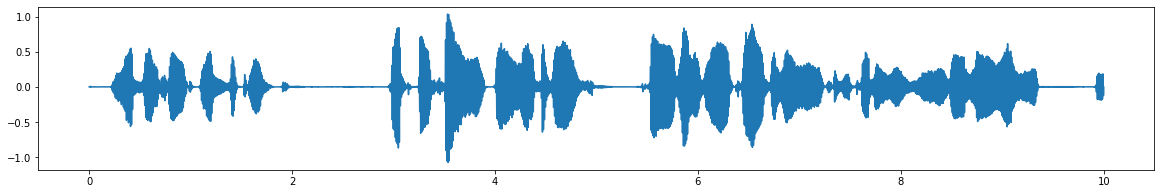

In [52]:
synth = sin(2*np.pi*100*tt)*filtered
plt.plot(tt, synth)
IPython.display.display(Audio(data=synth, rate=sr_all[1]))

# Beat Tracking

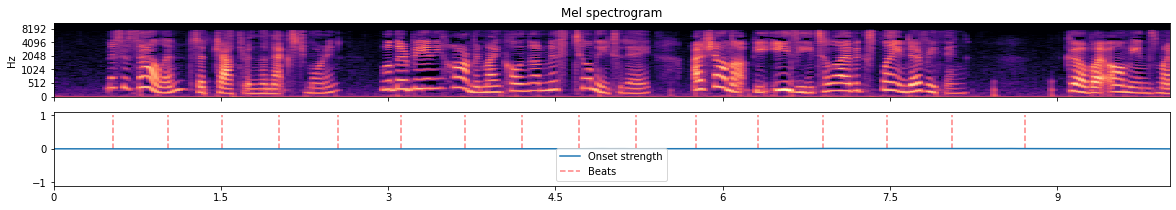

In [35]:
# https://librosa.org/doc/main/generated/librosa.beat.beat_track.html

import librosa.display

hop_length = 512
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(y_all[0], sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=y_all[0], sr=sr_all[0], hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])

tempo, beats = librosa.beat.beat_track(y=y_all[0], sr=sr_all[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(y_all[0]),
         label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax[1].legend()

# Can we track the chirp of each speaker's formant?

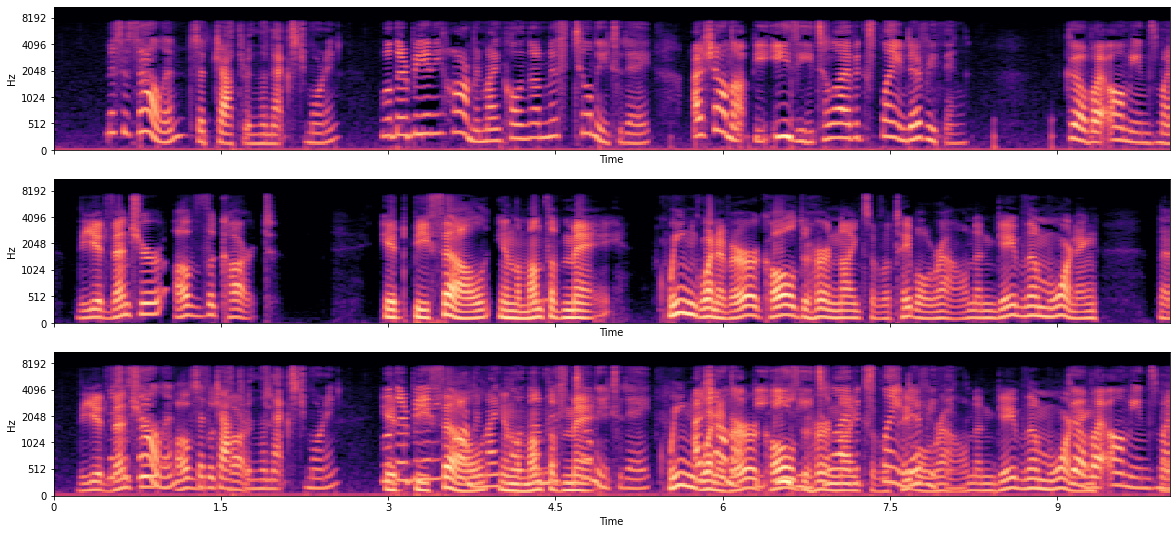

In [43]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(20, 9))

M = librosa.feature.melspectrogram(y=y_all[0], sr=sr_all[0], hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])

M = librosa.feature.melspectrogram(y=y_all[1], sr=sr_all[0], hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[1])

M = librosa.feature.melspectrogram(y=mix, sr=sr_all[0], hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[2])

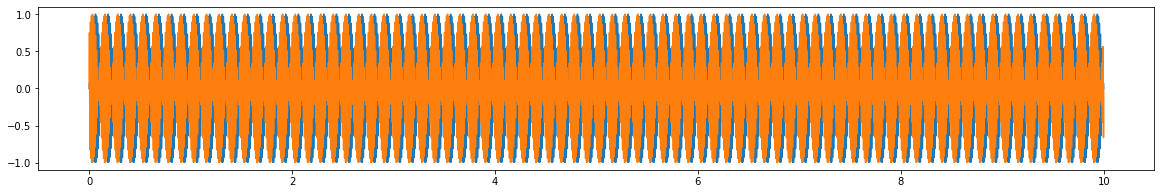

In [59]:
fund_Hz = 100 
syllable_Hz = 4
carrier = sin(2*π*fund_Hz*tt)
env1 = sin(2*π*syllable_Hz*tt)
env2 = sin(2*π*syllable_Hz*tt + π/4)
rhythm1 = carrier * env1
rhythm2 = carrier * env2

plt.plot(tt, rhythm1)
plt.plot(tt, rhythm2)

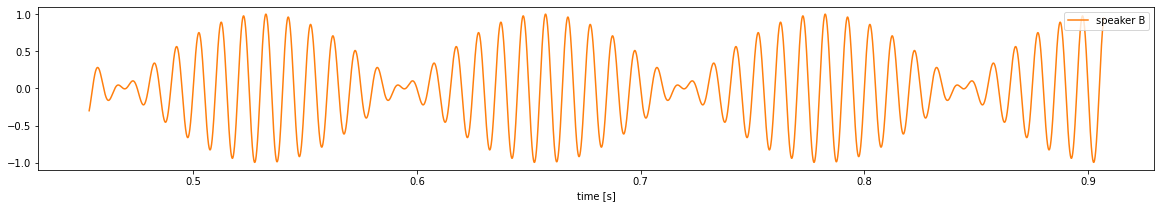

In [77]:
#plt.plot(tt[X_RANGE], rhythm1[X_RANGE], label='speaker A')
plt.plot(tt[X_RANGE], rhythm2[X_RANGE], c='#ff7f0e', label='speaker B')
plt.xlabel('time [s]')
plt.legend(loc='upper right')

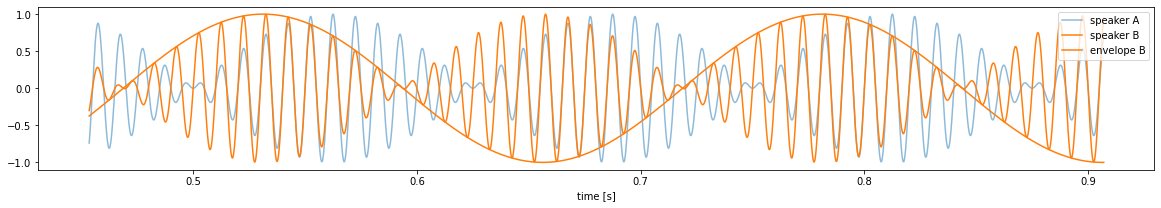

In [81]:
plt.plot(tt[X_RANGE], rhythm1[X_RANGE], alpha=0.5, label='speaker A')
plt.plot(tt[X_RANGE], rhythm2[X_RANGE], c='#ff7f0e', label='speaker B')
#plt.plot(tt[X_RANGE], env1[X_RANGE], c='#1f77b4', label='envelope A')
plt.plot(tt[X_RANGE], env2[X_RANGE], c='#ff7f0e', label='envelope B')

# colors: https://matplotlib.org/stable/users/prev_whats_new/dflt_style_changes.html

plt.xlabel('time [s]')
plt.legend(loc='upper right')